In [1]:
import numpy as np
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import sys
import os
import pickle

from gpflow.utilities import set_trainable, print_summary
gpflow.config.set_default_summary_fmt("notebook")

sys.path.append(os.path.split(os.path.split(os.getcwd())[0])[0]) # Move 3 levels up directory to import PBO
import PBO

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPU


In [4]:
def uniform_grid(input_dims, num_discrete_per_dim, low=0., high=1.):
    """
    Returns an array with all possible permutations of discrete values in input_dims number of dimensions.
    :param input_dims: int
    :param num_discrete_per_dim: int
    :param low: int
    :param high: int
    :return: tensor of shape (num_discrete_per_dim ** input_dims, input_dims)
    """
    num_points = num_discrete_per_dim ** input_dims
    out = np.zeros([num_points, input_dims])
    discrete_points = np.linspace(low, high, num_discrete_per_dim)
    for i in range(num_points):
        for dim in range(input_dims):
            val = num_discrete_per_dim ** (dim)
            out[i, dim] = discrete_points[int((i // val) % num_discrete_per_dim)]
    return out

In [5]:
def sample_maximizers_simple(model, num_maximizers, num_samples, input_dims, low, high):
    maximizers = np.zeros((num_maximizers, input_dims))
    for i in range(num_maximizers):
        xx = np.random.uniform(low, high, (num_samples, input_dims))
        samples = np.squeeze(model.predict_f_samples(xx, 1))  # (num_maximizers)
        samples_argmax = np.argmax(samples)
        maximizers[i] = xx[samples_argmax]
    return maximizers

## 1-D:

In [6]:
x_data = uniform_grid(1, 10, low=0.01, high=0.99)
y_data = np.expand_dims(-PBO.objectives.forrester(x_data), axis=1)

m = gpflow.models.SVGP(
                     kernel=gpflow.kernels.RBF(lengthscale=0.1),
                     likelihood=gpflow.likelihoods.Gaussian(),
                     inducing_variable=uniform_grid(1, 10, low=0.01, high=0.99))
m.kernel.lengthscale.trainable = False

In [7]:
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(lambda: -m.log_likelihood((x_data, y_data)), m.trainable_variables)

      fun: 30.14967858146299
 hess_inv: <77x77 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.01506693e-03, -8.67095369e-04, -4.57703732e-04, -1.31494792e-03,
       -3.41376031e-03, -5.60044858e-03, -8.35751482e-03, -2.07459319e-03,
       -6.64451532e-64, -1.38674696e-03, -7.61166819e-04,  4.43168307e-05,
        4.59826004e-05, -1.61242748e-04,  7.71050272e-05,  6.54854413e-04,
        1.17533768e-04,  4.46587281e-05, -1.56069391e-04, -7.56885601e-05,
        1.20682654e-03,  1.83535594e-04, -4.35129609e-04,  1.74821911e-04,
       -1.73453464e-04,  6.47949887e-04, -2.21015833e-04, -3.18060520e-04,
       -4.30472515e-04, -4.24035474e-04,  1.16507446e-04,  4.45284297e-04,
       -8.80304132e-04,  4.26157958e-07, -2.16191206e-05, -3.97834920e-05,
       -4.29164717e-06, -7.22672419e-08,  2.74019999e-08,  2.59526223e-09,
       -1.66479499e-09,  7.08074221e-09, -3.38941698e-04, -1.19464116e-03,
        3.03078471e-04,  1.71828909e-04, -1.31353476e-04,  1.73987285e-04,
  

In [8]:
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,27.825185335925223
SVGP.kernel.lengthscale,Parameter,Softplus,,False,(),float64,0.10000000000000007
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,3.2092957642985347
SVGP.inducing_variable.Z,Parameter,,,True,"(10, 1)",float64,[[0.12617248...
SVGP.q_mu,Parameter,,,True,"(10, 1)",float64,[[1.22194130e-01...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 10, 10)",float64,"[[[3.02005464e-01, 0.00000000e+00, 0.00000000e+00..."


(-0.0, 1.0)

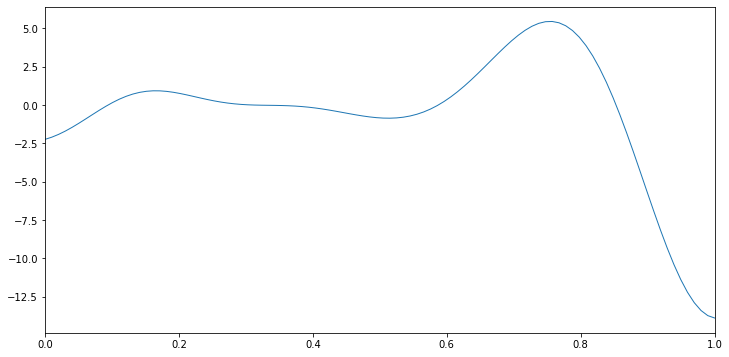

In [9]:
xx = np.linspace(0.0, 1.0, 100).reshape(100, 1)
plt.figure(figsize=(12, 6))
plt.plot(xx, m.predict_f(xx)[0], 'C0', linewidth=1)
plt.xlim(-0.0, 1.0)

In [10]:
sample_maximizers_simple(m, 100, 100, 1, 0., 1.)

array([[0.781478  ],
       [0.8009253 ],
       [0.17165754],
       [0.79339241],
       [0.74161852],
       [0.67638172],
       [0.71057066],
       [0.69975349],
       [0.75123377],
       [0.76338704],
       [0.74962687],
       [0.69765747],
       [0.78259495],
       [0.75250707],
       [0.7944301 ],
       [0.75129621],
       [0.75625946],
       [0.77050384],
       [0.25889798],
       [0.74535677],
       [0.77500237],
       [0.72020926],
       [0.78370408],
       [0.74965773],
       [0.76018035],
       [0.69989364],
       [0.74713012],
       [0.74984093],
       [0.75949881],
       [0.78265605],
       [0.7375387 ],
       [0.72936769],
       [0.71454122],
       [0.73341867],
       [0.74216228],
       [0.76981275],
       [0.72671947],
       [0.76887637],
       [0.72620232],
       [0.77158216],
       [0.7201291 ],
       [0.75105768],
       [0.70752655],
       [0.73802739],
       [0.77346443],
       [0.6500325 ],
       [0.80392688],
       [0.735

In [11]:
maximizers = PBO.fourier_features.sample_maximizers(X=m.inducing_variable.Z.numpy(),
                                                    count=100,
                                                    n_init=100,
                                                    D=100,
                                                    model=m,
                                                    min_val=0.,
                                                    max_val=1.)

Loss at step 0: 0.15979092590141303
Loss at step 389: -0.6608086974616019
test.shape =  (100, 100, 1)


In [12]:
maximizers

<tf.Tensor: shape=(100, 1), dtype=float64, numpy=
array([[0.70673574],
       [0.73035402],
       [0.69417076],
       [0.72815708],
       [0.69468181],
       [0.74901816],
       [0.60653106],
       [0.72629199],
       [0.71001773],
       [0.69492191],
       [0.71871795],
       [0.7393777 ],
       [0.70267014],
       [0.73297118],
       [0.75001526],
       [0.71726657],
       [0.77583322],
       [0.69287666],
       [0.77813042],
       [0.73094173],
       [0.72198069],
       [0.72779692],
       [0.70286184],
       [0.74019388],
       [0.72038062],
       [0.73145532],
       [0.24430546],
       [0.77541197],
       [0.72293256],
       [0.75863411],
       [0.70674869],
       [0.72182762],
       [0.71805624],
       [0.79681448],
       [0.75445556],
       [0.66060282],
       [0.74842712],
       [0.75638209],
       [0.73149689],
       [0.73534394],
       [0.64873578],
       [0.72673503],
       [0.72663234],
       [0.73679996],
       [0.74152713],
     

We see that in the 1-D case, both methods give reasonable results close to the peak of the function.

# 2-D:

In [82]:
x_data = uniform_grid(2, 10, low=-1.4, high=1.4)
y_data = np.expand_dims(-PBO.objectives.six_hump_camel(x_data), axis=1) + 7

m1 = gpflow.models.SVGP(
                     kernel=gpflow.kernels.RBF(lengthscale=[1.,1.]),
                     likelihood=gpflow.likelihoods.Gaussian(variance=1e-2),
                     inducing_variable=x_data,
                     whiten=False)

In [83]:
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(lambda: -m1.log_likelihood((x_data, y_data)), m1.trainable_variables)

      fun: -43.8819155410327
 hess_inv: <5354x5354 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00605981,  0.02627075,  0.01336166, ...,  0.01211857,
       -0.06794508, -0.09442562])
  message: b'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT'
     nfev: 15001
      nit: 14199
   status: 1
  success: False
        x: array([-3.7362924 , -3.49184518, -2.80247434, ..., -0.21263994,
        0.96893633,  2.93208573])

In [84]:
print_summary(m1)

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,22.754566200976754
SVGP.kernel.lengthscale,Parameter,Softplus,,True,"(2,)",float64,[1.31329632 0.63291897]
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.00014153681701700548
SVGP.inducing_variable.Z,Parameter,,,True,"(100, 2)",float64,"[[-3.73629240e+00, -3.49184518e+00..."
SVGP.q_mu,Parameter,,,True,"(100, 1)",float64,[[0.78816656...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 100, 100)",float64,"[[[3.13260828e+00, 0.00000000e+00, 0.00000000e+00..."


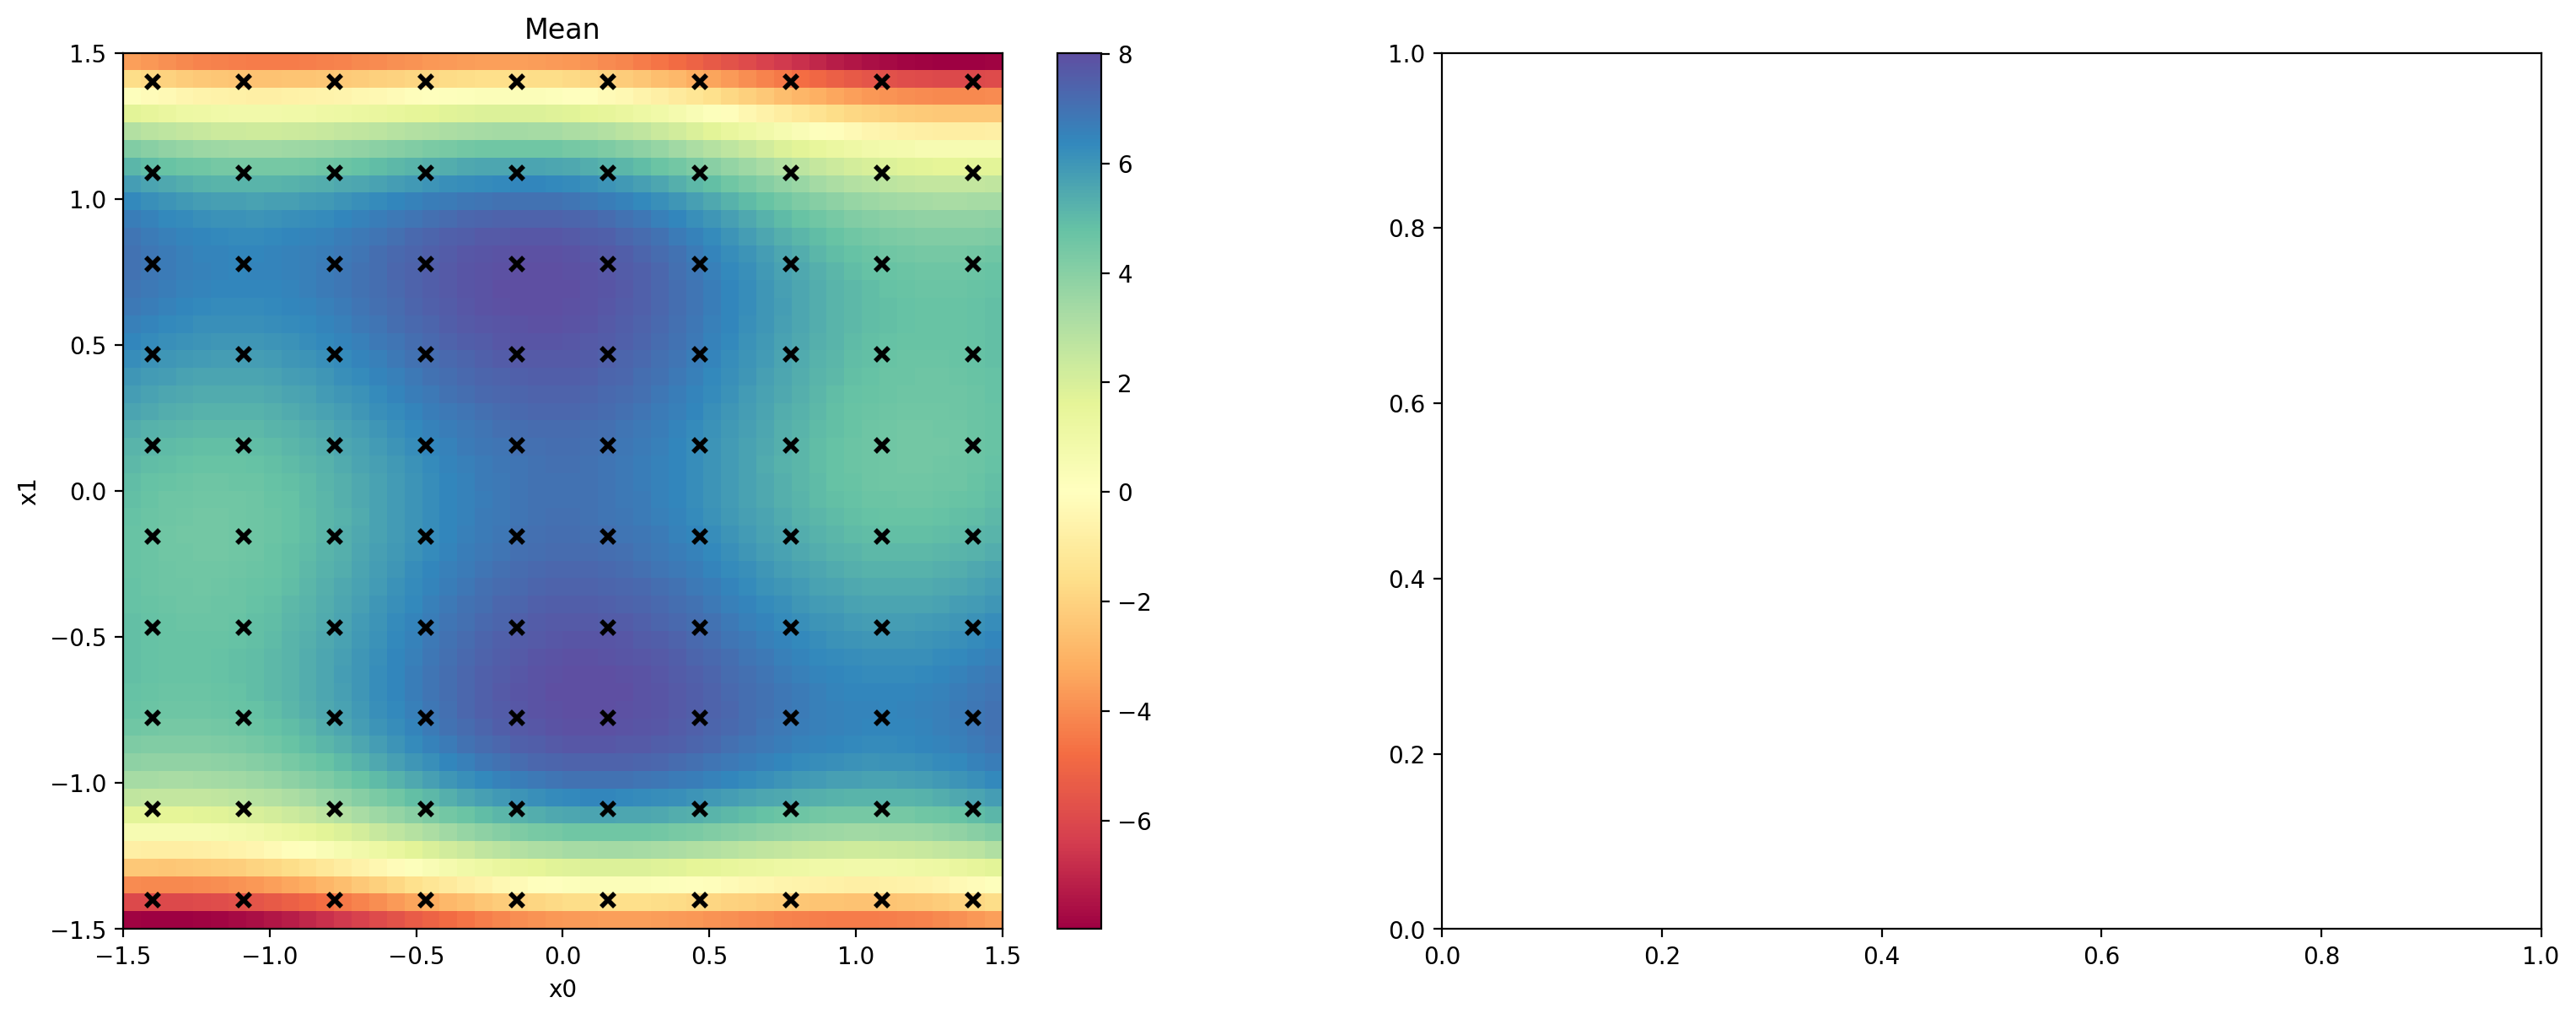

In [85]:
num_discrete_per_dim = 50
cmap = 'Spectral'
#side = np.linspace(objective_low, objective_high, num_discrete_per_dim)
side = np.linspace(-1.5, 1.5, num_discrete_per_dim)
combs = PBO.acquisitions.dts.combinations(np.expand_dims(side, axis=1))
predictions = m1.predict_y(combs)
preds = tf.transpose(tf.reshape(predictions[0], [num_discrete_per_dim, num_discrete_per_dim]))
variances = tf.transpose(tf.reshape(predictions[1], [num_discrete_per_dim, num_discrete_per_dim]))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 6.88)
fig.set_dpi((200))

ax1.axis('equal')
im1 = ax1.imshow(preds, 
                 interpolation='nearest', 
                 #extent=(objective_low, objective_high, objective_low, objective_high), 
                 extent=(-1.5, 1.5, -1.5, 1.5), 
                 origin='lower', 
                 cmap=cmap)
ax1.plot(x_data[:, 0], x_data[:, 1], 'kx', mew=2)

ax1.set_title("Mean")
ax1.set_xlabel("x0")
ax1.set_ylabel("x1")
fig.colorbar(im1, ax=ax1)

In [86]:
maximizers = sample_maximizers_simple(m1, 100, 100, 2, -1.5, 1.5)

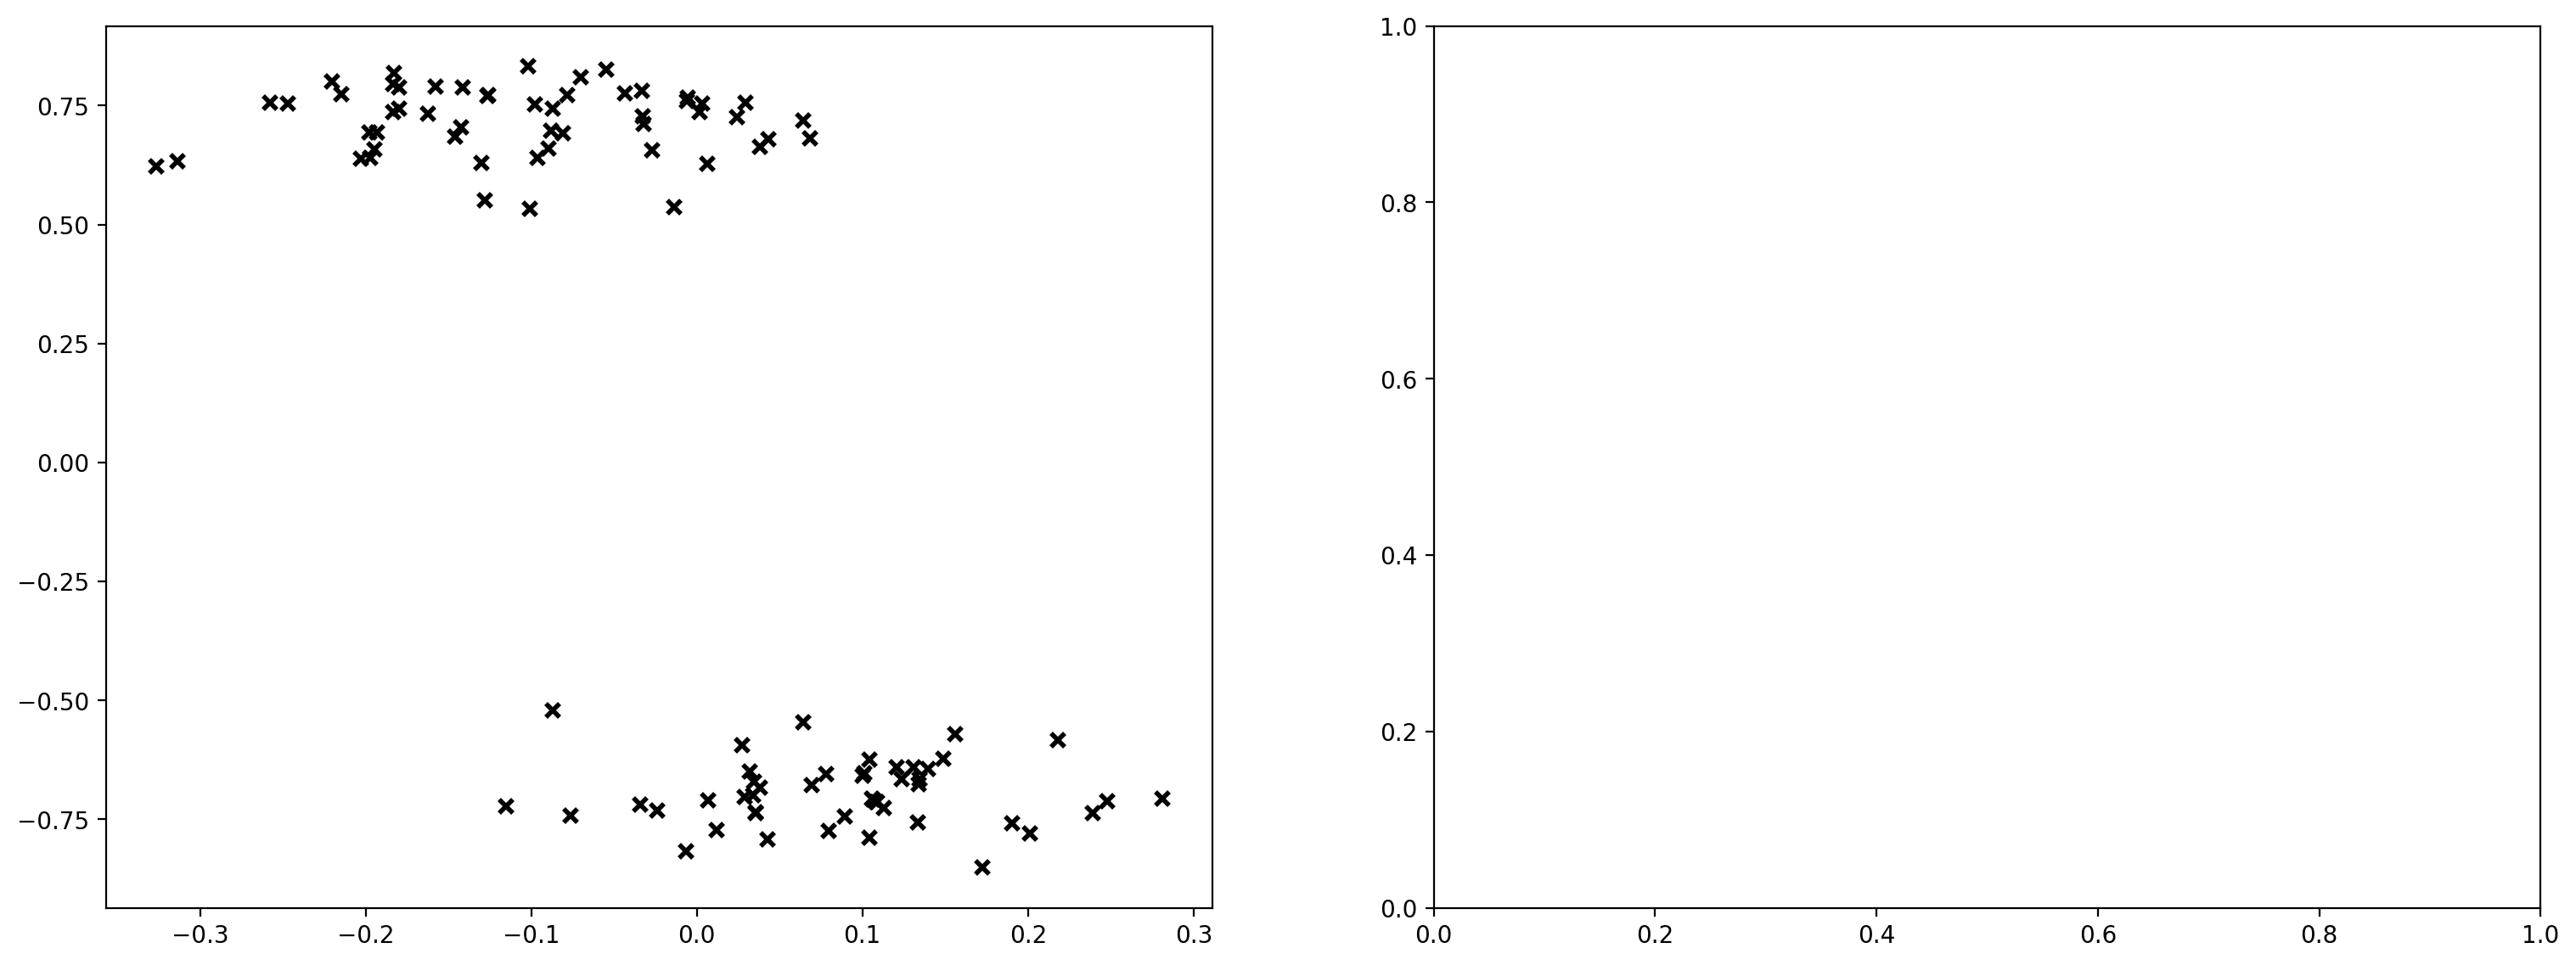

In [87]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 6.88)
fig.set_dpi((200))
ax1.plot(maximizers[:, 0], maximizers[:, 1], 'kx', mew=2)

We see that the simple method gives values centered around the 2 peaks at x = [0.0898, -0.7126] and x = [-0.0898, 0.7126]

In [88]:
maximizers = PBO.fourier_features.sample_maximizers(X=m1.inducing_variable.Z.numpy(),
                                                    count=50,
                                                    n_init=100,
                                                    D=1000,
                                                    model=m1,
                                                    min_val=-1.5,
                                                    max_val=1.5)

Loss at step 0: -4.499909572573311
Loss at step 500: -7.298675594585661
Loss at step 1000: -7.685494144103884
Loss at step 1420: -7.712841548860788
test.shape =  (50, 100, 1)


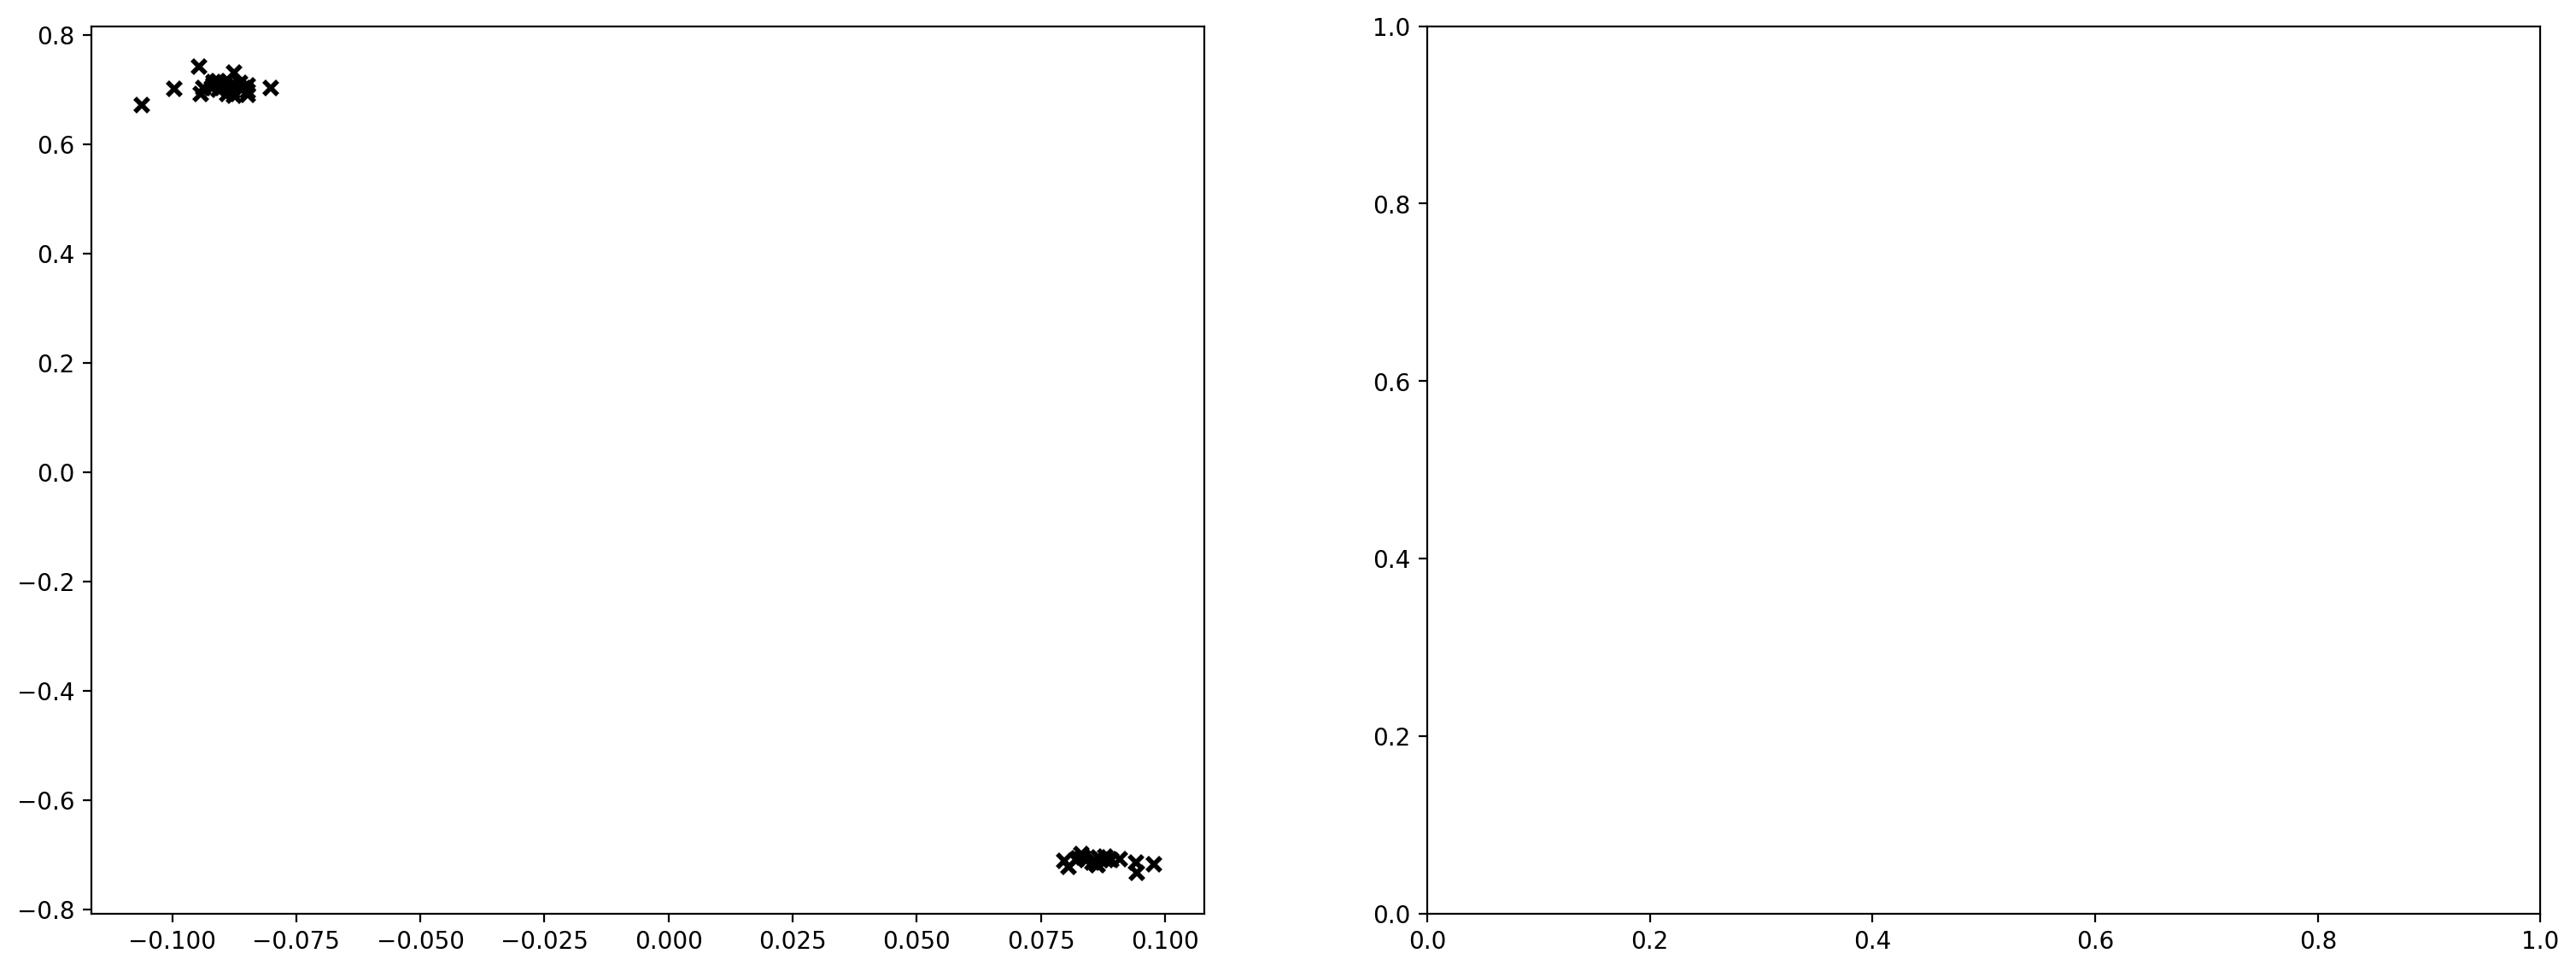

In [89]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 6.88)
fig.set_dpi((200))
ax1.plot(maximizers[:, 0], maximizers[:, 1], 'kx', mew=2)

Whereas the Fourier features method does not.

We test to see if the Fourier features method roughly approximates the model's kernel:

In [ ]:
test = np.array([[0.1, 0.3],
                 [0.3, 0.4],
                [0.5, 1.19]])

In [ ]:
m1.kernel.K(test)

In [ ]:
total = np.zeros((1,3,3))
for i in range(100):
    phi, W, b, theta = PBO.fourier_features.sample_features_weights(np.expand_dims(m1.inducing_variable.Z.numpy(), axis=0), m1, 100)
    ff_mat = PBO.fourier_features.fourier_features(np.expand_dims(test, axis=0), W, b)
    total += ff_mat @ tf.linalg.matrix_transpose(ff_mat)
print(total/100 * m1.kernel.variance.numpy()) 

And we see that it does. Hence the bug is probably somewhere after the Fourier features conversion (in the maximizing?)